In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

### Read in NDVI data

In [3]:
ds=xr.open_mfdataset(
    '/g/data/oe9/user/rg6346/VI_mask_nc/NDVI/NDVI_????.nc',
    chunks=dict(long=176)) 
ds=ds.rename({'ndvi_evi':'ndvi'})
ds=ds.drop('band')
ds['ndvi']=ds.ndvi/10000;
ds

<xarray.Dataset>
Dimensions:  (lat: 3147, long: 3344, time: 388)
Coordinates:
  * lat      (lat) float64 -24.59 -24.59 -24.6 -24.6 -24.6 -24.61 -24.61 ...
  * long     (long) float64 138.6 138.6 138.6 138.6 138.6 138.6 138.6 138.6 ...
  * time     (time) datetime64[ns] 2000-02-18 2000-03-05 2000-03-21 ...
Data variables:
    ndvi     (time, lat, long) float64 dask.array<shape=(388, 3147, 3344), chunksize=(20, 3147, 176)>

## Subset data for testing

In [4]:
sub=ds.sel(lat=slice(-30.1, -31),long=slice(148.9,150.6)) ##yarrie
sub.load()

<xarray.Dataset>
Dimensions:  (lat: 216, long: 408, time: 388)
Coordinates:
  * lat      (lat) float64 -30.1 -30.11 -30.11 -30.11 -30.12 -30.12 -30.13 ...
  * long     (long) float64 148.9 148.9 148.9 148.9 148.9 148.9 148.9 148.9 ...
  * time     (time) datetime64[ns] 2000-02-18 2000-03-05 2000-03-21 ...
Data variables:
    ndvi     (time, lat, long) float64 0.3499 0.3152 0.2693 0.2616 0.2476 ...

### Resample to quarterly, extract seasons

In [5]:
ndvi_q=sub.ndvi.resample(time='Q-FEB').mean(dim='time')
ndvi_jja=ndvi_q.where(ndvi_q['time.season']=='JJA',drop=True)
ndvi_djf=ndvi_q.where(ndvi_q['time.season']=='DJF',drop=True)


/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)
/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/g/data/oe9/software/anaconda/envs/geo/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


## Calculate and plot seasonal variance

In [6]:
#calculate stdev
ndvi_jja_std=ndvi_jja.std(dim='time')
ndvi_djf_std=ndvi_djf.std(dim='time')


In [7]:
both = xr.concat([ndvi_djf_std, ndvi_jja_std],dim=pd.Series(['DJF', 'JJA'], name='season', dtype='U'))
both

<xarray.DataArray (season: 2, lat: 216, long: 408)>
array([[[0.108663, 0.12152 , ..., 0.107392, 0.108449],
        [0.068411, 0.088082, ..., 0.099538, 0.096944],
        ...,
        [0.092365, 0.096102, ..., 0.065473, 0.067461],
        [0.103703, 0.094605, ..., 0.068367, 0.054098]],

       [[0.113357, 0.099587, ..., 0.093185, 0.085474],
        [0.129797, 0.101819, ..., 0.072853, 0.06771 ],
        ...,
        [0.161801, 0.154272, ..., 0.059472, 0.047602],
        [0.170902, 0.165734, ..., 0.063314, 0.044474]]])
Coordinates:
  * lat      (lat) float64 -30.1 -30.11 -30.11 -30.11 -30.12 -30.12 -30.13 ...
  * long     (long) float64 148.9 148.9 148.9 148.9 148.9 148.9 148.9 148.9 ...
  * season   (season) object 'DJF' 'JJA'

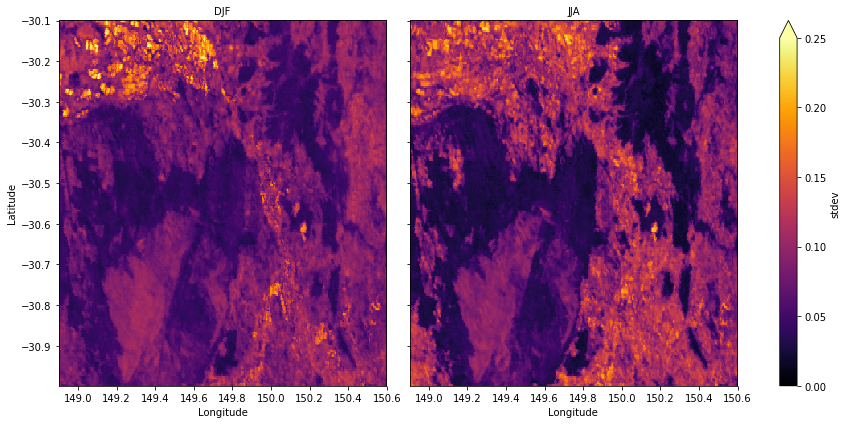

In [46]:
cmap='inferno'
vmin=0
vmax=.25
    
fig=plt.figure()
j = both.plot.imshow(col='season', robust=True,cmap=cmap,vmin=vmin, vmax=vmax,size=6)
j.cbar.set_label('stdev')
j.set_xlabels('Longitude')
j.set_ylabels('Latitude')
j.set_titles(template='{value}')
plt.ioff()

# fig.suptitle('Variance 2001-2016')

path='/home/156/jbw156/team-drip/figures/seasonalvariance_Yarrie.png'
plt.savefig(path,dpi=300,bbox_inches='tight')

In [47]:
## Plot time series

In [ ]:
## plot winter in loop
# save_path = '/home/156/jbw156/team-drip/figures/jja_ndvi/'
for step in ndvi_jja.time:
    fig=plt.figure()
    ndvi_jja.sel(time=step).plot.imshow(robust=True,cmap='Greens',vmin=0,vmax=.8)
#     plt.axes().set_aspect('equal', 'datalim')    
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    t=pd.to_datetime(step.values) 
    timestring = t.strftime('%Y')
    plt.title('Winter (JJA) '+timestring)
    
    completeName = os.path.join(save_path,"{y}jja_ndvi.png".format(y=timestring))  
    plt.savefig(completeName)
    plt.clf
#     print(timestring)